<a href="https://colab.research.google.com/github/amandaliusa/cs155-kaggle/blob/master/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [0]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv'] ))

In [0]:
# replace missing values with median (less sensitive to outliers)
df_train['opened_position_qty '].fillna(df_train['opened_position_qty '].median(),inplace=True)
df_test['opened_position_qty '].fillna(df_train['opened_position_qty '].median(),inplace=True)
df_train['closed_position_qty'].fillna(df_train['closed_position_qty'].median(),inplace=True)
df_test['closed_position_qty'].fillna(df_train['closed_position_qty'].median(), inplace=True)

In [0]:
df = pd.concat([df_train,df_test],sort=False)

In [0]:
# engineer new features by grouping like features and computing statistics on them 
bids = ['bid1','bid2', 'bid3', 'bid4', 'bid5']
bid_vols = ['bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol']
asks = ['ask1', 'ask2', 'ask3', 'ask4', 'ask5',]
ask_vols = ['ask1vol','ask2vol', 'ask3vol', 'ask4vol', 'ask5vol']
mid2 = ['bid2', 'ask2']
mid3 = ['bid3', 'ask3']
mid4 = ['bid4', 'ask4']
mid5 = ['bid5', 'ask5']

group_cols = {"bids":bids,"bid_vols":bid_vols,"asks":asks,"ask_vols":ask_vols}
group_cols2 = {"mid2":mid2, "mid3":mid3, "mid4":mid4, "mid5":mid5}

In [0]:
for group in group_cols.keys():
    df[f"{group}_max"] = df[group_cols[group]].max(axis=1)
    df[f"{group}_avg"] = df[group_cols[group]].mean(axis=1)
    df[f"{group}_std"] = df[group_cols[group]].std(axis=1)
    df[f"{group}_min"] = df[group_cols[group]].min(axis=1)
    df[f"{group}_spread"] = df[f"{group}_max"].div(df[f"{group}_min"])
  
for group in group_cols2.keys():
    # take average of bid/ask prices for 2,3,4,5
    df[f"{group}"] = df[group_cols2[group]].mean(axis=1)
      
df["last_price/mid"] = df["last_price"].div(df["mid"])

In [0]:
# split into training and test sets
x_train = df.loc[~df.y.isna()]
y_train = x_train['y']
x_train = x_train.drop(['y'], axis=1)
x_test = df.loc[df.y.isna()]
x_test = x_test.drop(['y'], axis=1)

In [0]:
# Normalize data
from sklearn import preprocessing

# Normalize training data by subtracting mean and scaling to unit variance
std_scale = preprocessing.StandardScaler().fit(x_train)
x_train_norm = std_scale.transform(x_train)
x_train = pd.DataFrame(x_train_norm, index=x_train.index, columns=x_train.columns)

# Normalize testing data by using mean and SD of training set
x_test_norm = std_scale.transform(x_test)
x_test = pd.DataFrame(x_test_norm, index=x_test.index, columns=x_test.columns) 

In [0]:
# Split training and validation data 
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [0]:
pip install xgboost

In [0]:
import xgboost as xgb
from xgboost import XGBClassifier

In [0]:
clf = XGBClassifier(n_estimators = 200, 
                       learning_rate = 0.05,
                       max_depth=6,
                       n_jobs=-1,
                       alpha = 0.1,
                    )
clf.fit(x_train, y_train, verbose=True)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
print(clf.score(x_train, y_train))
print(clf.score(x_val, y_val))

0.6756410581045951
0.6646071778250447


100 estimators, lr=0.05, alpha=0.1

For max_depth = 6:

0.6713068469563456

0.6630710017218677

val auc: 0.566313751416043

For max_depth = 9:

0.6925073432593943

0.6679749485127789

val auc: 0.5734175659260081

For max_depth 12:

0.7529351936257133

0.6701441642189135

val auc: 0.5791759764159015

For max_depth 15:

0.8527613187481009

0.6693929572234039

val auc: 0.5834126414719946

max_depth=6, , lr=0.05, alpha=0.1

For 50 estimators:

0.66781035821601

0.6612900503055471

val auc: 0.5612004556486119

In [0]:
y_pred = clf.predict(x_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('val auc: {}'.format(roc_auc))

val auc: 0.5707894518589454


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#using model.save_weights() to save the weights of the model in HDF5 format
df_test['Predicted'] = clf.predict_proba(x_test)[:,1]
df_test[["id","Predicted"]].to_csv('/content/gdrive/My Drive/submission_xgb5.csv', index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


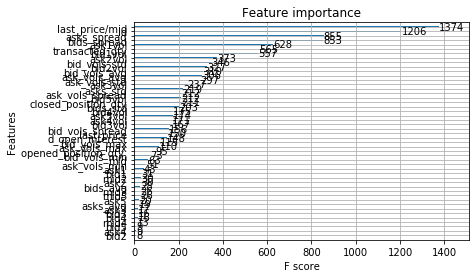

In [0]:
xgb.plot_importance(clf)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
df_test['Predicted'] = boosting3.predict_proba(x_test)[:,1]
df_test[["id","Predicted"]].to_csv('/content/gdrive/My Drive/submission_cat12.csv', index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
